In [32]:
import os 
import numpy as np
import pandas as pd 
import sklearn 
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df = pd.read_csv('../data/processed_data/mastersheet.csv')
df.head()

,AREA_NAME,Bachelor Leased,bachelor_avg_lease_rate,1_bedrooms_leased,1_bed_room_avg_lease_rate,2_bedrooms_leased,2_bedrooms_avg_lease_rate,3_bedrooms_leased,3_bedrooms_avg_lease_rate,area_sq_meters,...,max_stop_frequency,total_line_length_meters,transit_line_density,distinct_route_count,YEAR,avg_rent_1br,rent_lag_1,rent_lag_2,rent_growth_rate,TARGET_RENT_5YR
0,Agincourt North,0.333333,945.0,8.666667,1113.333333,16.333333,1407.000000,2.0,1483.500000,0.000813,...,807.0,1.755272,1.753847,10.0,2010,1113.333333,NaN,NaN,NaN,1342.250000
1,Agincourt North,0.000000,NaN,35.333333,1224.666667,39.666667,1424.666667,9.0,1618.000000,0.000813,...,807.0,1.755272,1.753847,10.0,2011,1224.666667,1113.333333,NaN,10.000000,1492.166667
2,Agincourt North,0.000000,NaN,21.000000,1272.750000,29.500000,1451.250000,3.5,1546.250000,0.000813,...,807.0,1.755272,1.753847,10.0,2012,1272.750000,1224.666667,1113.333333,3.926238,1644.833333
3,Agincourt North,0.000000,0.0,133.000000,1318.250000,179.000000,1484.250000,12.0,1650.333333,0.000813,...,807.0,1.755272,1.753847,10.0,2013,1318.250000,1272.750000,1224.666667,3.574936,1801.666667
4,Agincourt North,0.000000,0.0,135.000000,1301.500000,157.000000,1518.500000,10.0,1684.250000,0.000813,...,807.0,1.755272,1.753847,10.0,2014,1301.500000,1318.250000,1272.750000,-1.270624,1868.265625


In [34]:
# --- BACKFILLING CRIME RATES (2010-2013) ---
back_mults = {
    'ASSAULT_RATE': 0.969,
    'AUTOTHEFT_RATE': 0.939,
    'ROBBERY_RATE': 1.023,
    'SHOOTING_RATE': 0.879,
    'THEFTOVER_RATE': 0.953
}

print("Backfilling crime rates for 2010-2013")

if 2014 in df['YEAR'].values:
    df_2014 = df[df['YEAR'] == 2014]
    
    for year in [2013, 2012, 2011, 2010]:
        print(f"  Processing {year}...")
        steps_back = 2014 - year
        
        for col, mult in back_mults.items():
            if col not in df.columns:
                continue
                
            # Build lookup from 2014 data
            lookup = dict(zip(df_2014['AREA_NAME'], df_2014[col]))
            
            # FIX: Check for BOTH NaN AND 0 values
            mask = (df['YEAR'] == year) & ((df[col].isna()) | (df[col] == 0))
            
            for idx in df[mask].index:
                area = df.loc[idx, 'AREA_NAME']
                if area in lookup:
                    base_val = lookup[area]
                    imputed = base_val * (mult ** steps_back)
                    df.loc[idx, col] = imputed
                    
    print("Backfilling complete.")
else:
    print("Cannot backfill.")

# --- VERIFICATION ---
crime_cols = ['ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'SHOOTING_RATE', 'THEFTOVER_RATE']
print("\nValues after backfill:")
print(df[df['YEAR'].isin([2010, 2011, 2012, 2013])][['YEAR', 'AREA_NAME'] + crime_cols].head(20))

Backfilling crime rates for 2010-2013
  Processing 2013...
  Processing 2012...
  Processing 2011...
  Processing 2010...
Backfilling complete.

Values after backfill:
    YEAR                     AREA_NAME  ASSAULT_RATE  AUTOTHEFT_RATE  \
0   2010               Agincourt North    195.029051       43.635573   
1   2011               Agincourt North    201.268371       46.470259   
2   2012               Agincourt North    207.707297       49.489094   
3   2013               Agincourt North    214.352216       52.704040   
16  2010  Agincourt South-Malvern West    387.717732      108.483462   
17  2011  Agincourt South-Malvern West    400.121499      115.530843   
18  2012  Agincourt South-Malvern West    412.922083      123.036042   
19  2013  Agincourt South-Malvern West    426.132181      131.028799   
32  2010                     Alderwood    312.994210       56.453828   
33  2011                     Alderwood    323.007441       60.121223   
34  2012                     Alderwood  

In [35]:
# Verify backfilled crime rates for 2010-2013
crime_cols = ['ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'SHOOTING_RATE', 'THEFTOVER_RATE']

# Show a sample of the backfilled data
print("Sample of backfilled 2010-2013 data:")
print(df[df['YEAR'].isin([2010, 2011, 2012, 2013])][['YEAR', 'AREA_NAME'] + crime_cols].head(20))

# Check missing counts per year
print("\nMissing values per year after backfill:")
for year in [2010, 2011, 2012, 2013, 2014]:
    subset = df[df['YEAR'] == year]
    missing = subset[crime_cols].isna().sum().sum()
    print(f"  {year}: {missing} missing values")

Sample of backfilled 2010-2013 data:
    YEAR                     AREA_NAME  ASSAULT_RATE  AUTOTHEFT_RATE  \
0   2010               Agincourt North    195.029051       43.635573   
1   2011               Agincourt North    201.268371       46.470259   
2   2012               Agincourt North    207.707297       49.489094   
3   2013               Agincourt North    214.352216       52.704040   
16  2010  Agincourt South-Malvern West    387.717732      108.483462   
17  2011  Agincourt South-Malvern West    400.121499      115.530843   
18  2012  Agincourt South-Malvern West    412.922083      123.036042   
19  2013  Agincourt South-Malvern West    426.132181      131.028799   
32  2010                     Alderwood    312.994210       56.453828   
33  2011                     Alderwood    323.007441       60.121223   
34  2012                     Alderwood    333.341012       64.026861   
35  2013                     Alderwood    344.005173       68.186221   
48  2010                   

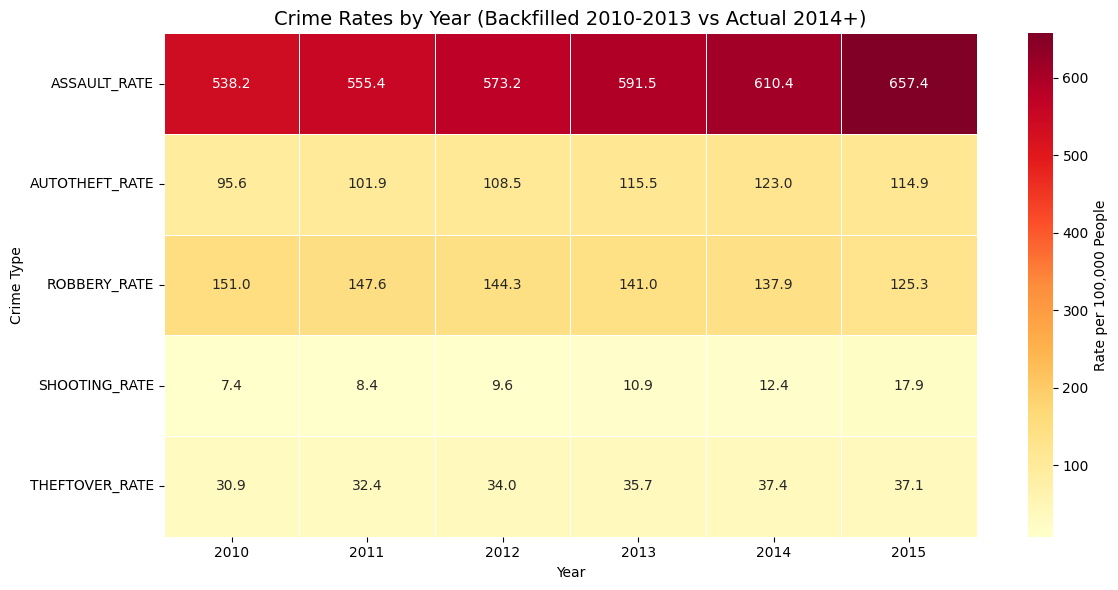


Crime rates by year:
      ASSAULT_RATE  AUTOTHEFT_RATE  ROBBERY_RATE  SHOOTING_RATE  \
YEAR                                                              
2010        538.20           95.64        150.98           7.42   
2011        555.42          101.86        147.59           8.44   
2012        573.18          108.47        144.27           9.60   
2013        591.52          115.52        141.02          10.92   
2014        610.45          123.02        137.85          12.42   
2015        657.35          114.92        125.32          17.92   

      THEFTOVER_RATE  
YEAR                  
2010           30.86  
2011           32.38  
2012           33.98  
2013           35.65  
2014           37.41  
2015           37.06  


In [36]:
# --- HEATMAP: Backfilled Crime Rates (2010-2013) ---
import matplotlib.pyplot as plt
import seaborn as sns

crime_cols = ['ASSAULT_RATE', 'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'SHOOTING_RATE', 'THEFTOVER_RATE']

# Calculate average crime rate per year
crime_by_year = df[df['YEAR'].isin([2010, 2011, 2012, 2013, 2014, 2015])].groupby('YEAR')[crime_cols].mean()

# Create heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    crime_by_year.T,  # Transpose: crimes on Y-axis, years on X-axis
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={'label': 'Rate per 100,000 People'}
)

plt.title('Crime Rates by Year (Backfilled 2010-2013 vs Actual 2014+)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Crime Type')
plt.tight_layout()

plt.savefig('crime_rates_backfilled_heatmap.png')
plt.show()

# Print the data for verification
print("\nCrime rates by year:")
print(crime_by_year.round(2))

In [37]:
df.columns

Index(['AREA_NAME', 'Bachelor Leased', 'bachelor_avg_lease_rate',
       '1_bedrooms_leased', '1_bed_room_avg_lease_rate', '2_bedrooms_leased',
       '2_bedrooms_avg_lease_rate', '3_bedrooms_leased',
       '3_bedrooms_avg_lease_rate', 'area_sq_meters', 'perimeter_meters',
       'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE', 'HOMICIDE_RATE',
       'ROBBERY_RATE', 'SHOOTING_RATE', 'THEFTOVER_RATE', 'POPULATION',
       'total_stop_count', 'avg_stop_frequency', 'max_stop_frequency',
       'total_line_length_meters', 'transit_line_density',
       'distinct_route_count', 'YEAR', 'avg_rent_1br', 'rent_lag_1',
       'rent_lag_2', 'rent_growth_rate', 'TARGET_RENT_5YR'],
      dtype='object')

In [38]:
# check relation of sparsity with year 

def analyze_sparsity(df):
    results = []
    
    for year, group in df.groupby('YEAR'):
        year_stats = {'YEAR': year, 'Total_Rows': len(group)}
        
        for col in df.columns:
            if col == 'YEAR': continue
            
            nulls = group[col].isna().sum()
            zeros = (group[col] == 0).sum()
            total_missing = nulls + zeros
            percent_missing = (total_missing / len(group)) * 100
            
            year_stats[f'{col}_missing_pct'] = round(percent_missing, 2)
            
        results.append(year_stats)

    return pd.DataFrame(results)

sparsity_report = analyze_sparsity(df)

# To make it readable, transpose it so years are columns and features are rows
print(sparsity_report.set_index('YEAR').T)

YEAR                                     2010    2011    2012    2013    2014  \
Total_Rows                             158.00  158.00  158.00  158.00  158.00   
AREA_NAME_missing_pct                    0.00    0.00    0.00    0.00    0.00   
Bachelor Leased_missing_pct             58.86   43.04   55.06   55.06   44.94   
bachelor_avg_lease_rate_missing_pct     58.86   45.57   55.06   55.06   44.94   
1_bedrooms_leased_missing_pct            0.00    0.00    0.00    0.00    0.00   
1_bed_room_avg_lease_rate_missing_pct    0.00    0.00    0.00    0.00    0.00   
2_bedrooms_leased_missing_pct            1.27    1.27    1.27    1.27    0.00   
2_bedrooms_avg_lease_rate_missing_pct    1.27    1.27    1.27    1.27    0.00   
3_bedrooms_leased_missing_pct           11.39    3.16   16.46    6.33   11.39   
3_bedrooms_avg_lease_rate_missing_pct   11.39    3.16   16.46    6.33   11.39   
area_sq_meters_missing_pct               0.00    0.00    0.00    0.00    0.00   
perimeter_meters_missing_pct

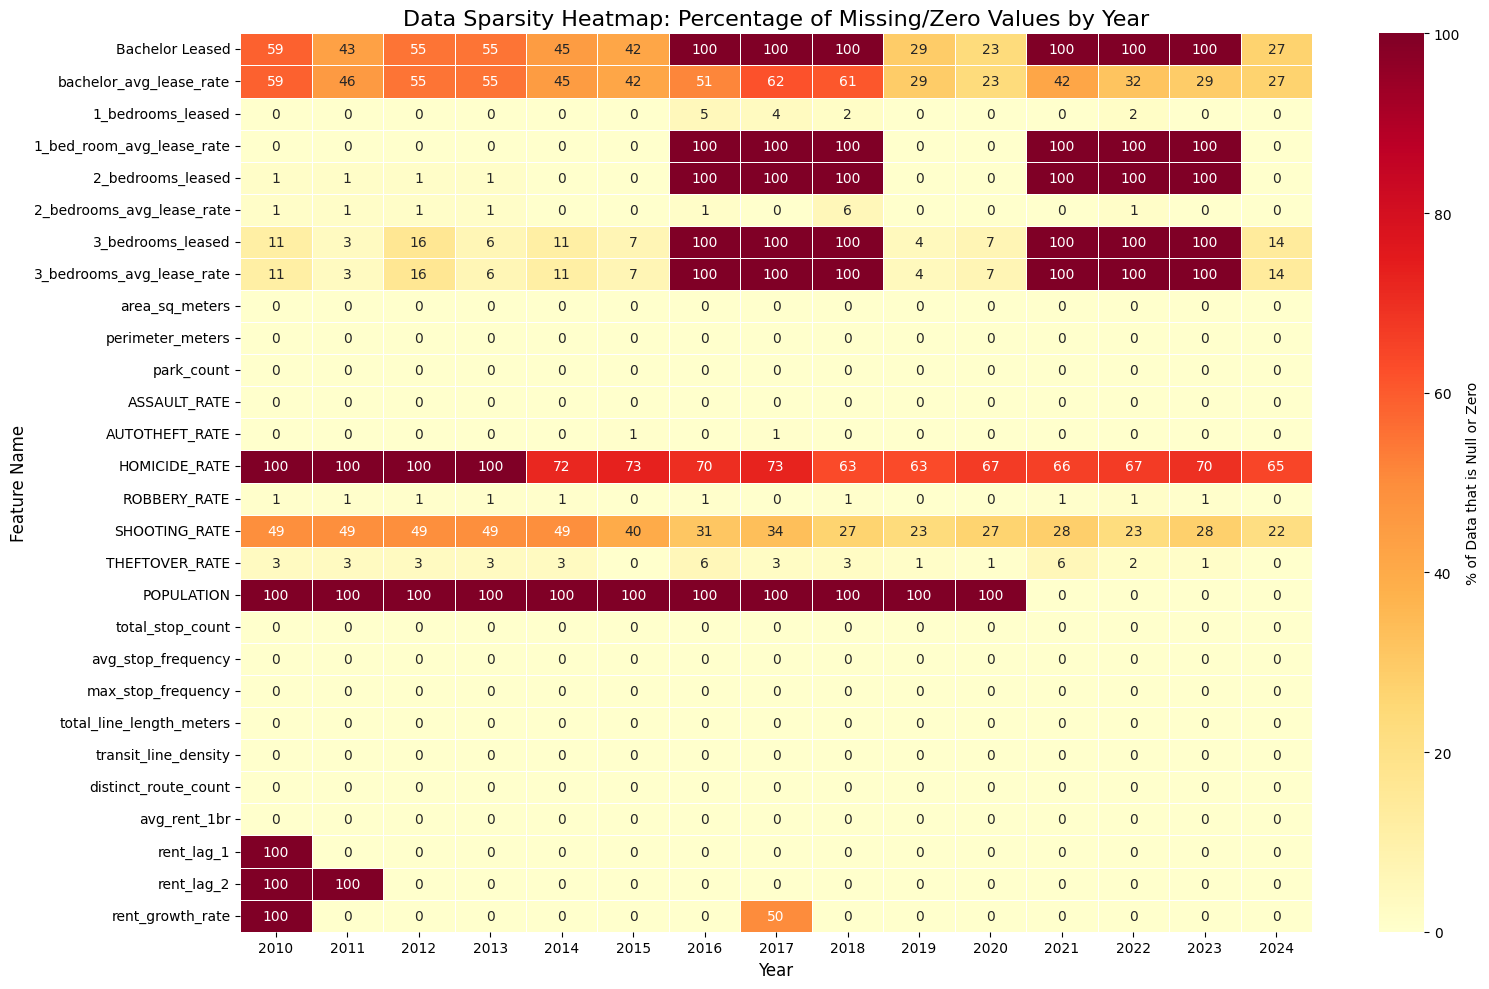

In [39]:
# sparsity matrix 

# 2. Identify features to analyze (exclude metadata like YEAR and AREA_NAME)
# We also exclude the TARGET because we expect it to be empty for recent years
features = [col for col in df.columns if col not in ['YEAR', 'AREA_NAME', 'TARGET_RENT_5YR']]

# Sparsmat: We define sparsity as (Nulls + Zeros) / Total Rows for that year
sparsity_list = []
years = sorted(df['YEAR'].unique())

for year in years:
    year_subset = df[df['YEAR'] == year]
    year_stats = {'YEAR': year}
    
    for col in features:
        # Calculate percentage of nulls or zeros
        missing_count = year_subset[col].isna().sum() + (year_subset[col] == 0).sum()
        sparsity_pct = (missing_count / len(year_subset)) * 100
        year_stats[col] = sparsity_pct
        
    sparsity_list.append(year_stats)

# Convert to DataFrame and transpose so Years are on the X-axis
sparsity_df = pd.DataFrame(sparsity_list).set_index('YEAR').T

# 4. Create the Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    sparsity_df, 
    annot=True,          # Show the actual percentages in the boxes
    fmt=".0f",           # Round to nearest whole number
    cmap="YlOrRd",       # Yellow to Red (Red = High Sparsity/Bad)
    linewidths=.5,
    cbar_kws={'label': '% of Data that is Null or Zero'}
)

plt.title('Data Sparsity Heatmap: Percentage of Missing/Zero Values by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()

# Save and show
plt.savefig('data_sparsity_heatmap.png')
plt.show()

# Findings 


The above heatmap is for both zeroes and null values. Pretty safe to say that we can treat 0s as effectively the same as NaNs in the specific case of condo renting; there is never going to be 0 rentals for a single neighborhood, logically speaking.

Regardless of how the year split is decided:

1. assault, autotheft, homicide, robbery, shooting, theftover rates are missing for all neighborhoods from 2010-2013. Imputation is not possible in this case, so options are: 1) removal of those years from the train set, or 2) removal of those variables from the train set. 
2. homicide rate has an average missing % of > 50 for all years. Removal is mandatory.
3. beyond 2010-2013, shooting rate has an average missing rate of 52% for all neighborhoods across 14 years. Removal is better than imputing in this case.
4. population is missing for all neighborhoods from 2010 - 2016. The Population is red across 71% of all years of data, so it should be dropped. 
5. 100% of rent_lag_1 is missing for all neighborhoods for a single year, which is normal for the first year, 2010. I should keep it.
6. 100% of rent_lag_2 is missing for 2010 and 2011, the first 2 years, which is normal. I should keep it.
7. 100% of rent_growth_rate is missing for all neighborhoods in 2010, and 50% is missing for 2017. I should keep 2010 as it is, since this is normal for the starting year to not have growth rate, and impute only 2017 data with linear interpolation.
8. bachelor leased is 70% missing for all neighborhoods for all years. Imputation is counter productive in this case, so removal is necessary. Same goes for bachelor average leased rate.
9. 1 bedrooms leased has 5% of data missing for 2016, 4% for 2017, 2% for 2018, and 2% for 2022. Imputation is possible.
10. 1 bedroom average leased rate has 100% missing values for all neighborhoods from 2016-2018 and 2021-2023, with 0% for the rest of the data.
11. 2 bedrooms leased has 1% of data missing from 2010-2013, and 100% of the data missing from 2016-2018 and 2021-2023. The rest of the years have 0% data missing. Both 9 and 10 have the same issue, where the data is extremely skewed. I think removal of either the years or the variable is necessary, but removing the entire feature or years causes removal of critical features along with the 100% missing block tumor.
12. 2 bedrooms average lease rate is missing for 1% of all neighborhoods for only 2010-2013, 2016, 2022, and 6% for 2018. Imputation is possible.
13. 3 bedrooms leased has 11% of its missing data for 2010 and 2014, 3% for 2011, 16% for 2012, 7% for 2015, 100% from 2016 to 2018, 4% for 2019, 7% for 2020, 100% for 2021 to 2023, 14% for 2024. On average, 48.5% of data is missing across all years. I think removal of this variable is necessary, but it would remove a critical feature.
14. 3 bedrooms average least rate is identical to 3 bedrooms leased.

# Proposal Solution, Rawdogging Gemini-Advised Anti Gooning DataMaxxing No Cap FrFr:

- hard truncate 2010-2013 data, and only work with 2014-2024 for ongoing dataset? 
- drop homicide rate and shooting rate due to >40% missing data for all neighborhoods on all years on average
- backfill population from 2021 onwards, population is a slow growth and the outcome would not change much
- keep rent lags and rent growth rate, but impute the outliers for rent growth rate for 2017
- drop 3 bedrooms leased and 3 bedrooms avg leas rate
- drop 1 bedroom average lease rate and keep avg rent 1 br 
- 2 bedrooms leased is missing some entries, but 2 bedrooms __avg lease rate__ is not missing much. Drop 2 bedrooms and keep 2 bedrooms avg lease rate
- drop bachelor leased and bachelor avg leased, >40% average missing values across all neighborhoods for all years


NOTE: Strongly suspect missing crime rates data from 2010-2013 is due to a human error. The 100% missing checker might be due to human data, but might also be TREB issue. Suspected to be TREB issue, not with the pipeline.

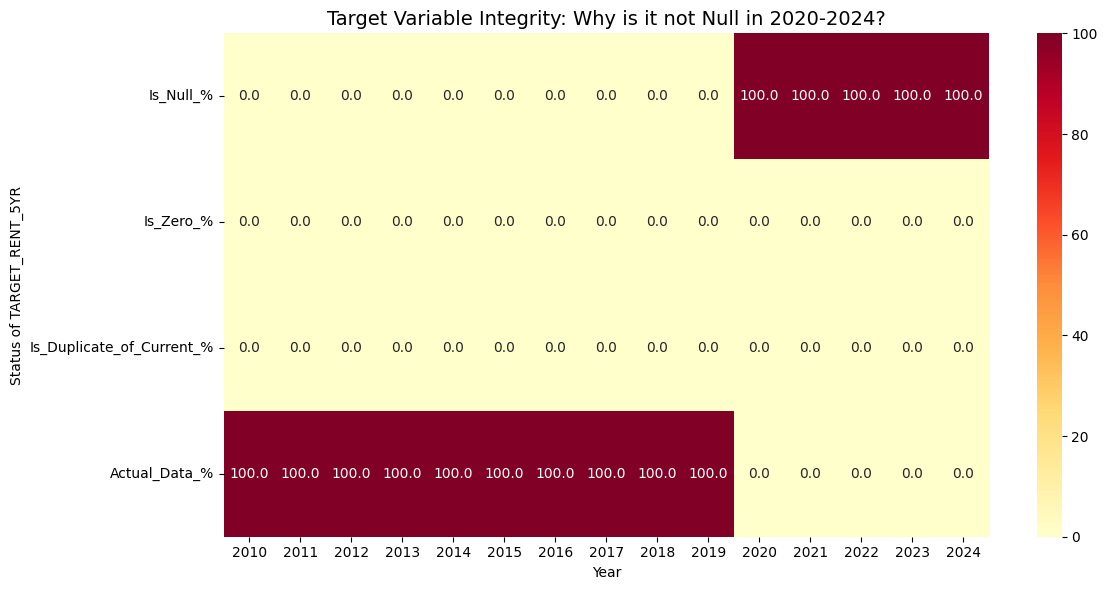

Sample values for 2024 TARGET_RENT_5YR:
                       AREA_NAME  avg_rent_1br  TARGET_RENT_5YR
15               Agincourt North        2220.0              NaN
31  Agincourt South-Malvern West        2220.0              NaN
47                     Alderwood        2448.0              NaN
63                         Annex        2665.0              NaN
79                      Avondale        2379.0              NaN


In [40]:
# checking if the target variable, the predicted rent for 5 years ahead, is missing  


# Create a targeted analysis for the TARGET column
target_analysis = []
years = sorted(df['YEAR'].unique())

for year in years:
    subset = df[df['YEAR'] == year]
    total = len(subset)
    
    # Check for NaNs
    nulls = subset['TARGET_RENT_5YR'].isna().sum()
    
    # Check for Zeros
    zeros = (subset['TARGET_RENT_5YR'] == 0).sum()
    
    # Check for "Current Rent Duplication" (Common Leakage)
    # This checks if the target is EXACTLY the same as the current rent
    duplicates = (subset['TARGET_RENT_5YR'] == subset['avg_rent_1br']).sum()
    
    target_analysis.append({
        'YEAR': year,
        'Is_Null_%': (nulls / total) * 100,
        'Is_Zero_%': (zeros / total) * 100,
        'Is_Duplicate_of_Current_%': (duplicates / total) * 100,
        'Actual_Data_%': ((total - nulls - zeros - duplicates) / total) * 100
    })

# Convert to DataFrame for plotting
debug_df = pd.DataFrame(target_analysis).set_index('YEAR').T

# 3. Plot the Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(debug_df, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title('Target Variable Integrity: Why is it not Null in 2020-2024?', fontsize=14)
plt.ylabel('Status of TARGET_RENT_5YR')
plt.xlabel('Year')
plt.tight_layout()

# plt.savefig('target_debug_heatmap.png')
plt.show()

# 4. Print sample values for 2024 to see what's actually there
print("Sample values for 2024 TARGET_RENT_5YR:")
print(df[df['YEAR'] == 2024][['AREA_NAME', 'avg_rent_1br', 'TARGET_RENT_5YR']].head())

The target variable looks right; there is no data for it from 2020-2024. So 2020-2024 must be dropped too. 

# Outline 

1. drop all rows with years from 2020-2024, and 2010-2013 data.
2. drop columns homicide rate and shooting rate, 3 bedrooms leased, 3 bedrooms avg lease rate, 1 bedroom average lease rate, 2 bedrooms leased, bachelor leased, bachelor average leased rate
4. backfill population from 2021 backwards
5. plot the sparsity heatmap again, and see what strategies to use for imputation before splitting (linear interpolation, KNN, binary)
6. split the data by year, (should) drop the year (which has no use after splitting, but this will be kept for model trainer), neighborhoods name (same as year), then impute 

In [41]:
# 0. keep the 2021 year population for all neighborhoods for backfilling; there are 0 missing values for it 

pop_2021_df = df[df['YEAR'] == 2021][['AREA_NAME', 'POPULATION']].drop_duplicates()

# check if 2021 pop has any missing values 
nulls = pop_2021_df['POPULATION'].isna().sum()

print(nulls)

0


In [42]:
# no missing vals for 2021, so we good 

pop_lookup = dict(zip(pop_2021_df['AREA_NAME'], pop_2021_df['POPULATION']))

print(pop_lookup)

{'Agincourt North': 30426.0, 'Agincourt South-Malvern West': 29799.0, 'Alderwood': 13746.0, 'Annex': 35899.0, 'Avondale': 16084.0, 'Banbury-Don Mills': 34089.0, 'Bathurst Manor': 17529.0, 'Bay-Cloverhill': 22880.0, 'Bayview Village': 28366.0, 'Bayview Woods-Steeles': 14142.0, 'Bedford Park-Nortown': 25101.0, 'Beechborough-Greenbrook': 7717.0, 'Bendale South': 11576.0, 'Bendale-Glen Andrew': 21422.0, 'Birchcliffe-Cliffside': 25508.0, 'Black Creek': 23038.0, 'Blake-Jones': 8157.0, 'Briar Hill-Belgravia': 16842.0, 'Bridle Path-Sunnybrook-York Mills': 12137.0, 'Broadview North': 11992.0, 'Brookhaven-Amesbury': 19410.0, 'Cabbagetown-South St.James Town': 12676.0, 'Caledonia-Fairbank': 10785.0, 'Casa Loma': 13128.0, 'Centennial Scarborough': 14882.0, 'Church-Wellesley': 27123.0, 'Clairlea-Birchmount': 30413.0, 'Clanton Park': 20967.0, 'Cliffcrest': 18285.0, 'Corso Italia-Davenport': 14119.0, 'Danforth': 9913.0, 'Danforth East York': 18201.0, 'Don Valley Village': 30772.0, 'Dorset Park': 2737

In [43]:
# 1. drop all rows with years from 2020-2024 and 2010-2013

initial_count = len(df)
dropped_df = df[(df['YEAR'] >= 2014) & (df['YEAR'] <= 2019)]

rows_dropped = initial_count - len(dropped_df)
print(f"Initial row count: {initial_count}")
print(f"Rows dropped (2010-2013 & 2020-2024): {rows_dropped}")
print(f"Remaining rows for training/testing: {len(df)}")

print(f"New Year Range: {dropped_df['YEAR'].min()} to {dropped_df['YEAR'].max()}")

Initial row count: 2528
Rows dropped (2010-2013 & 2020-2024): 1422
Remaining rows for training/testing: 2528
New Year Range: 2014 to 2019


In [44]:
df.columns

Index(['AREA_NAME', 'Bachelor Leased', 'bachelor_avg_lease_rate',
       '1_bedrooms_leased', '1_bed_room_avg_lease_rate', '2_bedrooms_leased',
       '2_bedrooms_avg_lease_rate', '3_bedrooms_leased',
       '3_bedrooms_avg_lease_rate', 'area_sq_meters', 'perimeter_meters',
       'park_count', 'ASSAULT_RATE', 'AUTOTHEFT_RATE', 'HOMICIDE_RATE',
       'ROBBERY_RATE', 'SHOOTING_RATE', 'THEFTOVER_RATE', 'POPULATION',
       'total_stop_count', 'avg_stop_frequency', 'max_stop_frequency',
       'total_line_length_meters', 'transit_line_density',
       'distinct_route_count', 'YEAR', 'avg_rent_1br', 'rent_lag_1',
       'rent_lag_2', 'rent_growth_rate', 'TARGET_RENT_5YR'],
      dtype='object')

In [45]:
drop_cols = ['HOMICIDE_RATE', 'SHOOTING_RATE', '3_bedrooms_leased', '3_bedrooms_avg_lease_rate', 
             '1_bed_room_avg_lease_rate', '2_bedrooms_leased', 'Bachelor Leased', 'bachelor_avg_lease_rate']

dropped_df = dropped_df.drop(columns=drop_cols)

In [46]:
dropped_df.columns

Index(['AREA_NAME', '1_bedrooms_leased', '2_bedrooms_avg_lease_rate',
       'area_sq_meters', 'perimeter_meters', 'park_count', 'ASSAULT_RATE',
       'AUTOTHEFT_RATE', 'ROBBERY_RATE', 'THEFTOVER_RATE', 'POPULATION',
       'total_stop_count', 'avg_stop_frequency', 'max_stop_frequency',
       'total_line_length_meters', 'transit_line_density',
       'distinct_route_count', 'YEAR', 'avg_rent_1br', 'rent_lag_1',
       'rent_lag_2', 'rent_growth_rate', 'TARGET_RENT_5YR'],
      dtype='object')

In [47]:
# 1. Verification: Check for name mismatches before replacing
missing = [name for name in df['AREA_NAME'].unique() if name not in pop_lookup]
print(missing)

[]


In [48]:
dropped_df['POPULATION'] = dropped_df['AREA_NAME'].map(pop_lookup)

# 3. Final Check: Ensure no NaNs were created by the mapping
if dropped_df['POPULATION'].isna().any():
    print(f"Post-map check: {dropped_df['POPULATION'].isna().sum()} rows r nulls")
else:
    print("No null values found. We chilling.")

No null values found. We chilling.


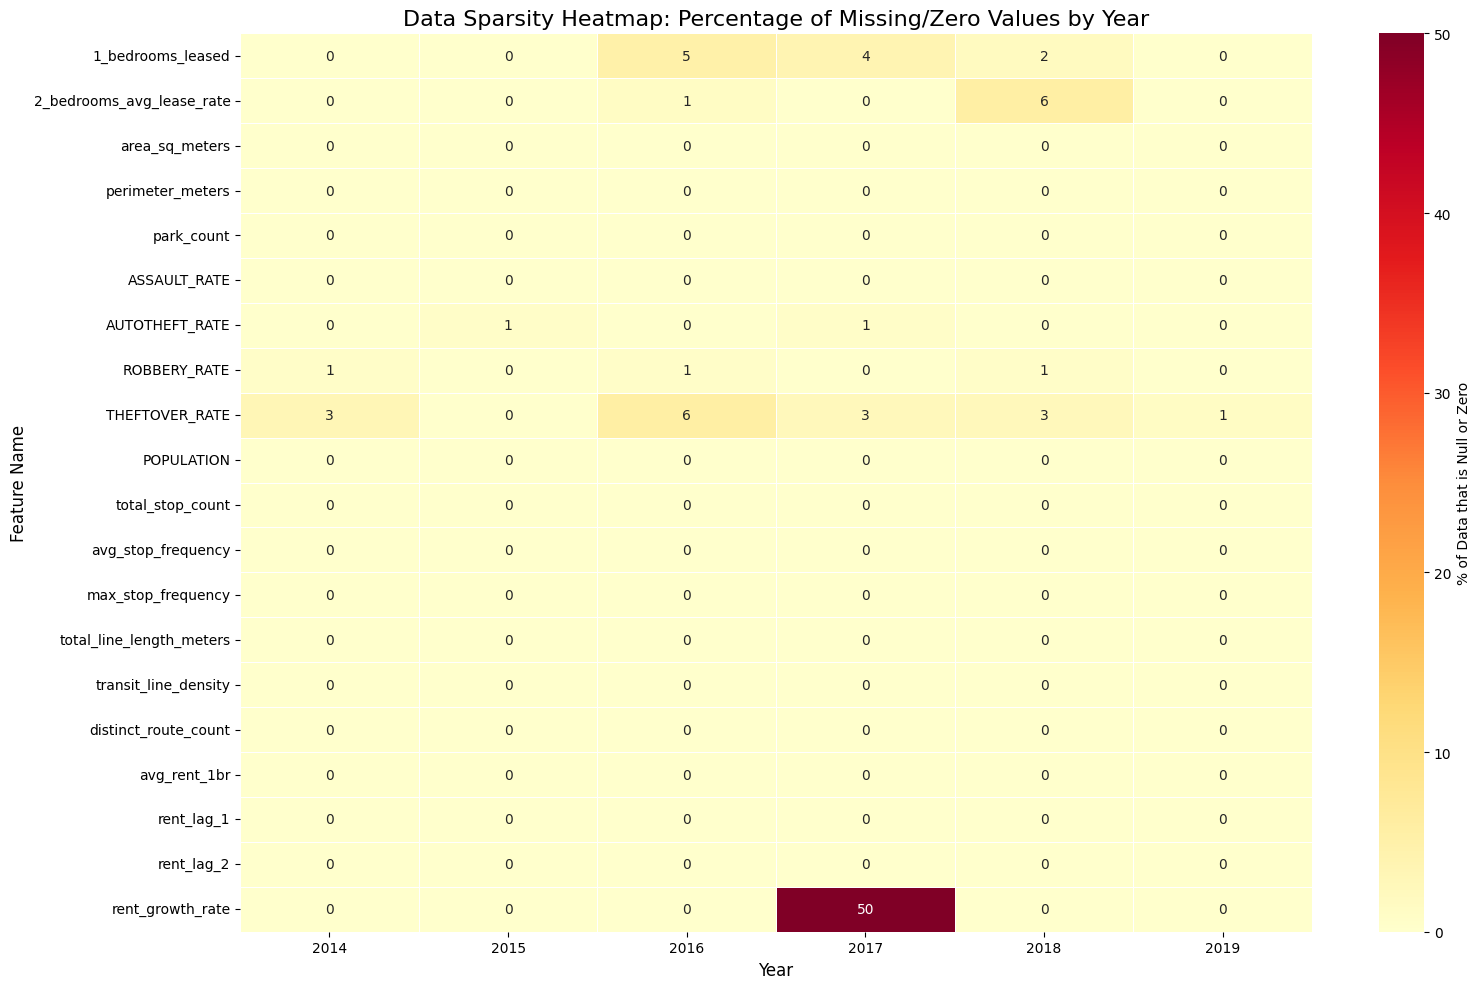

In [49]:
# plot sparsity heatmap again to check 
features = [col for col in dropped_df.columns if col not in ['YEAR', 'AREA_NAME', 'TARGET_RENT_5YR']]

# Sparsmat: We define sparsity as (Nulls + Zeros) / Total Rows for that year
sparsity_list = []
years = sorted(dropped_df['YEAR'].unique())

for year in years:
    year_subset = dropped_df[dropped_df['YEAR'] == year]
    year_stats = {'YEAR': year}
    
    for col in features:
        # Calculate percentage of nulls or zeros
        missing_count = year_subset[col].isna().sum() + (year_subset[col] == 0).sum()
        sparsity_pct = (missing_count / len(year_subset)) * 100
        year_stats[col] = sparsity_pct
        
    sparsity_list.append(year_stats)

# Convert to DataFrame and transpose so Years are on the X-axis
sparsity_df = pd.DataFrame(sparsity_list).set_index('YEAR').T

# 4. Create the Heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    sparsity_df, 
    annot=True,          # Show the actual percentages in the boxes
    fmt=".0f",           # Round to nearest whole number
    cmap="YlOrRd",       # Yellow to Red (Red = High Sparsity/Bad)
    linewidths=.5,
    cbar_kws={'label': '% of Data that is Null or Zero'}
)

plt.title('Data Sparsity Heatmap: Percentage of Missing/Zero Values by Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.tight_layout()
plt.show()

In [50]:
print(len(dropped_df.columns))

23


# Missing values mostly dealt with  

At the great sacrifices of the years 2010-2013, and the columns `['HOMICIDE_RATE', 'SHOOTING_RATE', '3_bedrooms_leased', '3_bedrooms_avg_lease_rate', '1_bed_room_avg_lease_rate', '2_bedrooms_leased', 'Bachelor Leased', 'bachelor_avg_lease_rate']`, data now oiled up and does not have missing chunks. Rest in peace `drop_cols`, your sacrifice will be remembered. `#neverforget`


# Features to be imputed: 

1. rent_growth_rate for 2017 only (50% missing for all neighborhoods)
2. THEFTOVER_RATE
3. ROBBERY_RATE
4. AUTOTHEFT_RATE
5. 2_bedrooms_avg_lease_rate
6. 1_bedrooms_leased


`rent_growth_rate`: Linear Interpolation, growth rate is trend based and time-series, and 2016 & 2018 data are present.
`THEFTOVER_RATE`: KNN + binary indicator; crime is usually correlated with other neighborhood features (population & density).
`ROBBERY_RATE`: median imputation + binary indicator; usually skewed with many 0s. 
`AUTOTHEFT_RATE`: median + binary; same as above.
`2_bedrooms_avg_lease_rate`: forward fill (inflation is sticky and prices only go up).
`1_bedrooms_leased`: mean imputation by neighborhood, number of units leased is volume metric so historical mean keeps scale right.



# Strategy 

1. linearly interpolate all `rent_growth_rate` missing for 2017 first
2. forward fill the `2_bedrooms_avg_lease_rate`
3. add binary indicators to `ROBBERY_RATE`, `AUTOTHEFT_RATE`, `THEFTOVER_RATE`: 1 for missing, 0 for present. Entry is considered missing if it is both 0 value and NaN.
4. Add a new years_since_baseline as baseline for the training data; this is calculated as CURRENT_YEAR - 2014.
5. split the data: 2014-2017 as train, 2018-2019 as test
6. carry out KNN impuation for `THEFTOVER_RATE`, median imputation for `ROBBERY_RATE`, `AUTOTHEFT_RATE`, and `1_bedrooms_leased`
7. drop the area name, year, separate the train y and test y as numpy arrays  

In [51]:
# pre split 

dropped_df = dropped_df.sort_values(['AREA_NAME', 'YEAR'])

# step 1 
dropped_df['rent_growth_rate'] = df.groupby('AREA_NAME')['rent_growth_rate'].transform(
    lambda x: x.interpolate(method='linear')
)

# step 2 
dropped_df['2_bedrooms_avg_lease_rate'] = dropped_df.groupby('AREA_NAME')['2_bedrooms_avg_lease_rate'].transform(
    lambda x: x.ffill().bfill() # bfill handles cases where 2014 is the missing value
)

# step 3 
crime_cols = ['THEFTOVER_RATE', 'ROBBERY_RATE', 'AUTOTHEFT_RATE']
for col in crime_cols:
    dropped_df[f'is_missing_{col}'] = ((dropped_df[col] == 0) | (dropped_df[col].isna())).astype(int) # missing means NaN and 0; 
    # realistically not possible for crime rate of a single neighborhood to be zero even for Batman 

# step 4: baseline for keeping track of year for XGBoost 
dropped_df['years_since_baseline'] = dropped_df['YEAR'] - 2014 

In [52]:
dropped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1106 entries, 4 to 2522
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  1106 non-null   object 
 1   1_bedrooms_leased          1106 non-null   float64
 2   2_bedrooms_avg_lease_rate  1106 non-null   float64
 3   area_sq_meters             1106 non-null   float64
 4   perimeter_meters           1106 non-null   float64
 5   park_count                 1106 non-null   float64
 6   ASSAULT_RATE               1106 non-null   float64
 7   AUTOTHEFT_RATE             1103 non-null   float64
 8   ROBBERY_RATE               1103 non-null   float64
 9   THEFTOVER_RATE             1078 non-null   float64
 10  POPULATION                 1106 non-null   float64
 11  total_stop_count           1106 non-null   float64
 12  avg_stop_frequency         1106 non-null   float64
 13  max_stop_frequency         1106 non-null   float64
 1

In [53]:
dropped_df.head()

,AREA_NAME,1_bedrooms_leased,2_bedrooms_avg_lease_rate,area_sq_meters,perimeter_meters,park_count,ASSAULT_RATE,AUTOTHEFT_RATE,ROBBERY_RATE,THEFTOVER_RATE,...,YEAR,avg_rent_1br,rent_lag_1,rent_lag_2,rent_growth_rate,TARGET_RENT_5YR,is_missing_THEFTOVER_RATE,is_missing_ROBBERY_RATE,is_missing_AUTOTHEFT_RATE,years_since_baseline
4,Agincourt North,135.0,1518.5,0.000813,0.134458,10.0,221.209717,56.127838,118.858955,3.301638,...,2014,1301.500000,1318.250000,1272.750000,-1.270624,1868.265625,0,0,0,0
5,Agincourt North,110.0,1547.5,0.000813,0.134458,10.0,257.275543,96.895988,123.625916,20.047445,...,2015,1342.250000,1301.500000,1318.250000,3.131003,1821.479821,0,0,0,1
6,Agincourt North,25.0,1749.0,0.000813,0.134458,10.0,274.091644,60.166462,50.138718,16.712906,...,2016,1492.166667,1342.250000,1301.500000,11.169057,1893.166667,0,0,0,2
7,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1492.166667,1342.250000,10.231207,1823.333333,0,0,0,3
8,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1644.833333,1492.166667,0.000000,1823.333333,0,0,0,3


In [54]:
len(dropped_df.columns)

27

In [55]:
# step 4; split 
train_df = dropped_df[dropped_df['YEAR'] <= 2017].copy()
test_df = dropped_df[dropped_df['YEAR'] > 2017].copy()

# step 5 
from sklearn.impute import KNNImputer 

for col in ['ROBBERY_RATE', 'AUTOTHEFT_RATE']: # median impute for crime rates 
    train_median = train_df[col].median()
    train_df[col] = train_df[col].replace(0, np.nan).fillna(train_median)
    test_df[col] = test_df[col].replace(0, np.nan).fillna(train_median)


for name in train_df['AREA_NAME'].unique(): # median impute for 1_bedrooms_leased for all areas 
    n_mean = train_df[train_df['AREA_NAME'] == name]['1_bedrooms_leased'].mean()
    
    # Apply to Train
    train_df.loc[train_df['AREA_NAME'] == name, '1_bedrooms_leased'] = train_df.loc[train_df['AREA_NAME'] == name, '1_bedrooms_leased'].fillna(n_mean)
    # Apply to Test
    test_df.loc[test_df['AREA_NAME'] == name, '1_bedrooms_leased'] = test_df.loc[test_df['AREA_NAME'] == name, '1_bedrooms_leased'].fillna(n_mean)


knn = KNNImputer(n_neighbors=5)

# exclude the features that are not relevant: target variable, year, binary (one hot encoded) crime data for missing values, 
# and discrete time values like year baseline 
knn_features_subset = list(dropped_df.columns)
exclude = ['AREA_NAME', 'YEAR', 'TARGET_RENT_5YR', 'is_missing_THEFTOVER_RATE', 'is_missing_ROBBERY_RATE', 
           'is_missing_AUTOTHEFT_RATE', 'years_since_baseline']
knn_features_subset = [col for col in knn_features_subset if col not in exclude]

knn_feature_subset = [
    'POPULATION', 'area_sq_meters', 'avg_rent_1br', 
    '2_bedrooms_avg_lease_rate', 'THEFTOVER_RATE'
]


train_filled = knn.fit_transform(train_df[knn_feature_subset])
test_filled = knn.transform(test_df[knn_feature_subset])

# only update THEFTOVER 
train_df['THEFTOVER_RATE'] = train_filled[:, -1]
test_df['THEFTOVER_RATE'] = test_filled[:, -1]

In [56]:
train_df.head()

,AREA_NAME,1_bedrooms_leased,2_bedrooms_avg_lease_rate,area_sq_meters,perimeter_meters,park_count,ASSAULT_RATE,AUTOTHEFT_RATE,ROBBERY_RATE,THEFTOVER_RATE,...,YEAR,avg_rent_1br,rent_lag_1,rent_lag_2,rent_growth_rate,TARGET_RENT_5YR,is_missing_THEFTOVER_RATE,is_missing_ROBBERY_RATE,is_missing_AUTOTHEFT_RATE,years_since_baseline
4,Agincourt North,135.0,1518.5,0.000813,0.134458,10.0,221.209717,56.127838,118.858955,3.301638,...,2014,1301.500000,1318.250000,1272.750000,-1.270624,1868.265625,0,0,0,0
5,Agincourt North,110.0,1547.5,0.000813,0.134458,10.0,257.275543,96.895988,123.625916,20.047445,...,2015,1342.250000,1301.500000,1318.250000,3.131003,1821.479821,0,0,0,1
6,Agincourt North,25.0,1749.0,0.000813,0.134458,10.0,274.091644,60.166462,50.138718,16.712906,...,2016,1492.166667,1342.250000,1301.500000,11.169057,1893.166667,0,0,0,2
7,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1492.166667,1342.250000,10.231207,1823.333333,0,0,0,3
8,Agincourt North,20.0,1883.0,0.000813,0.134458,10.0,252.993759,111.317253,74.211502,37.105751,...,2017,1644.833333,1644.833333,1492.166667,0.000000,1823.333333,0,0,0,3


In [57]:
test_df.head()

,AREA_NAME,1_bedrooms_leased,2_bedrooms_avg_lease_rate,area_sq_meters,perimeter_meters,park_count,ASSAULT_RATE,AUTOTHEFT_RATE,ROBBERY_RATE,THEFTOVER_RATE,...,YEAR,avg_rent_1br,rent_lag_1,rent_lag_2,rent_growth_rate,TARGET_RENT_5YR,is_missing_THEFTOVER_RATE,is_missing_ROBBERY_RATE,is_missing_AUTOTHEFT_RATE,years_since_baseline
9,Agincourt North,28.0,2089.000000,0.000813,0.134458,10.0,272.025574,142.813431,149.614059,13.601278,...,2018,1801.666667,1644.833333,1644.833333,9.534907,2464.500000,0,0,0,4
10,Agincourt North,128.0,2213.356589,0.000813,0.134458,10.0,277.920746,144.107056,126.951447,10.293361,...,2019,1868.265625,1801.666667,1644.833333,3.696519,2220.000000,0,0,0,5
25,Agincourt South-Malvern West,28.0,2089.000000,0.000881,0.166170,15.0,471.261139,153.059174,132.919800,40.278728,...,2018,1801.666667,1644.833333,1644.833333,9.534907,2464.500000,0,0,0,4
26,Agincourt South-Malvern West,128.0,2213.356589,0.000881,0.166170,15.0,484.193665,232.092834,112.044815,60.024010,...,2019,1868.265625,1801.666667,1644.833333,3.696519,2220.000000,0,0,0,5
41,Alderwood,148.0,2885.000000,0.000555,0.098569,12.0,237.116669,189.693329,63.231110,55.327221,...,2018,2909.666667,2141.166667,2141.166667,35.891648,3092.166667,0,0,0,4


In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 790 entries, 4 to 2520
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  790 non-null    object 
 1   1_bedrooms_leased          790 non-null    float64
 2   2_bedrooms_avg_lease_rate  790 non-null    float64
 3   area_sq_meters             790 non-null    float64
 4   perimeter_meters           790 non-null    float64
 5   park_count                 790 non-null    float64
 6   ASSAULT_RATE               790 non-null    float64
 7   AUTOTHEFT_RATE             790 non-null    float64
 8   ROBBERY_RATE               790 non-null    float64
 9   THEFTOVER_RATE             790 non-null    float64
 10  POPULATION                 790 non-null    float64
 11  total_stop_count           790 non-null    float64
 12  avg_stop_frequency         790 non-null    float64
 13  max_stop_frequency         790 non-null    float64
 14

In [59]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 9 to 2522
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   AREA_NAME                  316 non-null    object 
 1   1_bedrooms_leased          316 non-null    float64
 2   2_bedrooms_avg_lease_rate  316 non-null    float64
 3   area_sq_meters             316 non-null    float64
 4   perimeter_meters           316 non-null    float64
 5   park_count                 316 non-null    float64
 6   ASSAULT_RATE               316 non-null    float64
 7   AUTOTHEFT_RATE             316 non-null    float64
 8   ROBBERY_RATE               316 non-null    float64
 9   THEFTOVER_RATE             316 non-null    float64
 10  POPULATION                 316 non-null    float64
 11  total_stop_count           316 non-null    float64
 12  avg_stop_frequency         316 non-null    float64
 13  max_stop_frequency         316 non-null    float64
 14

In [60]:
# export data 

train_df.to_csv('train.csv', index=False)
test_df.to_csv('test.csv', index=False)

# DONE

Data is now cleaned. When training, please remove AREA_NAME and YEAR, and separate the target variable for both train_df and test_df. 